In [1]:
!pip install librosa

In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from collections import OrderedDict

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [3]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [4]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft = 1024, hop_length = 512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft = n_fft,
        hop_length = hop_length)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

In [5]:
def read_data(src_dir, genres, song_samples, spec_format, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_specs = []
    arr_genres = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                print(file_name)
                signal, sr = librosa.load(file_name)
                signal = signal[:song_samples]
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Convert to dataset of spectograms/melspectograms
                signals, y = splitsongs(signal, genres[x])
                
                # Convert to "spec" representation
                specs = spec_format(signals)
                
                # Save files
                arr_genres.extend(y)
                arr_specs.extend(specs)
                
                
    return np.array(arr_specs), np.array(arr_genres)

In [6]:
# Parameters
gtzan_dir = './instruments_classifier_training/'
song_samples = 110000
genres = {'piano': 0, 'guitar': 1 }

In [7]:
# # Read the data
# X, y = read_data(gtzan_dir, genres, song_samples, to_melspectrogram, debug=False)
# np.save('x_instruments_classifier_training.npy', X)
# np.save('y_instruments_classifier_training.npy', y)

In [8]:
X = np.load('x_instruments_classifier_training.npy')
y = np.load('y_instruments_classifier_training.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'x_instruments_classifier_training.npy'

In [9]:
# One hot encoding of the labels
y = to_categorical(y)

# Dataset Split

In [10]:
X_stack = np.squeeze(np.stack((X,) * 3, -1))
X_stack.shape

(136078, 128, 22, 3)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_stack, y, test_size=0.2, random_state=42, stratify = y)

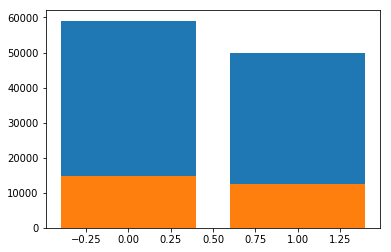

In [12]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# Training

In [13]:
# Model Definition

model_name = 'CNN'
input_shape = X_train[0].shape

num_genres = 2

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',input_shape=input_shape))
#model.add(LeakyReLU(alpha=0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(128, (3, 3)))
#model.add(LeakyReLU(alpha=0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(256, (3, 3)))
#model.add(LeakyReLU(alpha=0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

# model.add(Conv2D(512, (3, 3)))
# #model.add(LeakyReLU(alpha=0.1))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.20))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))
#model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(num_genres))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 22, 64)       1792      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 22, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 11, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 9, 128)        73856     
_________________________________________________________________
activation_2 (Activation)    (None, 62, 9, 128)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 4, 128)        0         
__________

In [14]:
model_path = './models/CNN.h5'

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

batch_size = 128
epochs = 50

In [15]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks = [checkpoint, earlystop])

Train on 108862 samples, validate on 27216 samples
Epoch 1/50
108862/108862 [==============================] - 21s 194us/step - loss: 0.4032 - acc: 0.8294 - val_loss: 0.2683 - val_acc: 0.8827

Epoch 00001: val_loss improved from inf to 0.26827, saving model to ./CNN.h5
Epoch 2/50
108862/108862 [==============================] - 18s 164us/step - loss: 0.2136 - acc: 0.9171 - val_loss: 0.1530 - val_acc: 0.9397

Epoch 00002: val_loss improved from 0.26827 to 0.15302, saving model to ./CNN.h5
Epoch 3/50
108862/108862 [==============================] - 19s 171us/step - loss: 0.1419 - acc: 0.9471 - val_loss: 0.1083 - val_acc: 0.9582

Epoch 00003: val_loss improved from 0.15302 to 0.10826, saving model to ./CNN.h5
Epoch 4/50
108862/108862 [==============================] - 18s 169us/step - loss: 0.1081 - acc: 0.9608 - val_loss: 0.0840 - val_acc: 0.9688

Epoch 00004: val_loss improved from 0.10826 to 0.08396, saving model to ./CNN.h5
Epoch 5/50
108862/108862 [==============================] - 1

In [16]:
# # Model Definition
# input_shape = X_train[0].shape
# num_genres = 4

# def cnn_vgg16(input_shape, num_genres, freezed_layers):
#     input_tensor = Input(shape=input_shape)
#     vgg16 = VGG16(include_top=False, weights='imagenet',
#                   input_tensor=input_tensor)

#     top = Sequential()
#     top.add(Flatten(input_shape=vgg16.output_shape[1:]))
#     top.add(Dense(256, activation='relu'))
#     top.add(Dropout(0.5))
#     top.add(Dense(num_genres, activation='softmax'))

#     model = Model(inputs=vgg16.input, outputs=top(vgg16.output))
#     for layer in model.layers[:freezed_layers]:
#         layer.trainable = False

#     return model

# model = cnn_vgg16(input_shape, num_genres, 10)
# model.summary()

In [17]:
# model_path = './models/instruments_classifier.h5'

# checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
# earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# batch_size = 128
# epochs = 50

In [18]:
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adam(10e-4),
#               metrics=['accuracy'])

# hist = model.fit(X_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(X_test, y_test),
#           callbacks = [checkpoint, earlystop])

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.011 and val_acc = 0.996


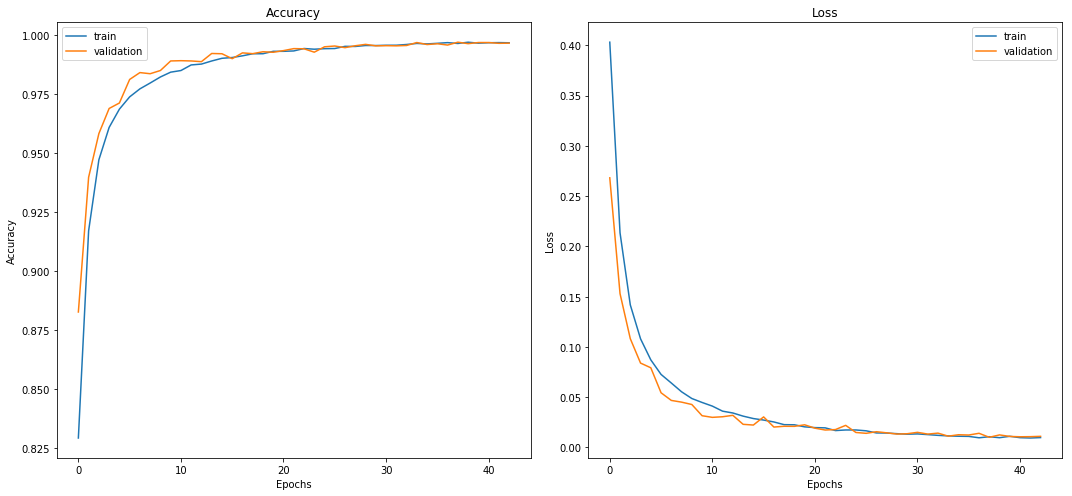

In [20]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


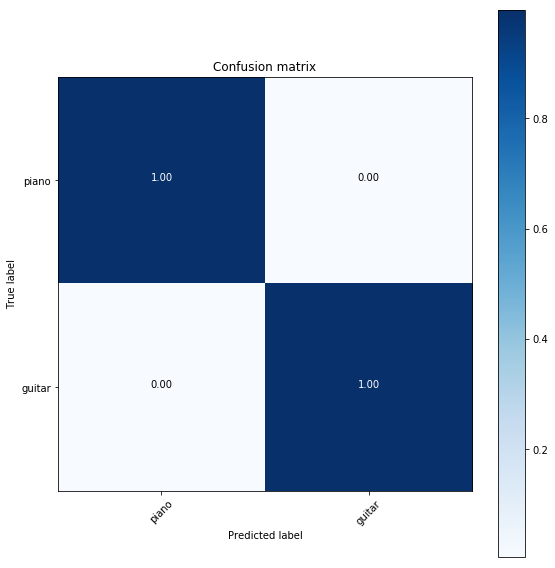

In [23]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

## Test data process

In [8]:
#load model
model = load_model('../models/CNN.h5')

In [98]:
# Parameters
#test_dir = '../instruments_classifier_testing/'
test_dir = './demo/piano/sounds_like_guitar/'
#test_dir = './demo/guitar/'
song_samples = 110000
genres_key = {'piano': 0, 'guitar': 1 }

In [99]:
def create_filename_list(src_dir):
    filename_list = []
    for root, subdirs, files in os.walk(src_dir):
        for file in files:
            filename_list.append(file)
    return filename_list

In [100]:
def read_test_data(src_dir, song_samples, spec_format):
    arr_specs = []
    music_splits_len = []
    
    for root, subdirs, files in os.walk(src_dir):
        for file in files:
            file_name = src_dir + "/" + file
            signal, sr = librosa.load(file_name)
            
            # target_samples = signal.shape[0] - (signal.shape[0] % sr)
            signal = signal[:song_samples]
                        
            # Convert to dataset of spectograms/melspectograms
            signals = splitsongs_for_test(signal, music_splits_len)
                
            # Convert to "spec" representation
            specs = spec_format(signals)
                
            # Save files
            arr_specs.extend(specs)
    return np.array(arr_specs), music_splits_len

In [101]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs_for_test(X, music_splits_len, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
    music_splits_len.append(len(temp_X))
    return np.array(temp_X)

In [102]:
# Read the data
test_x, music_splits_len = read_test_data(test_dir, song_samples, to_melspectrogram)
np.save('test_x_instruments_classifier.npy', test_x)

In [103]:
X_test = np.load('test_x_instruments_classifier.npy')

In [104]:
X_test_stack = np.squeeze(np.stack((X_test,) * 3, -1))

In [105]:
predict_result = model.predict(X_test_stack)

In [106]:
# 將每首歌的預測結果結合在一起
def group_predict_result(predict_result, music_splits_len):
    grouping_predict_result = []
    delete_result = predict_result
    for length in music_splits_len:
        temp_grouping = []
        for i in range(length):
            temp_grouping.append(delete_result[0])
            delete_result = np.delete(delete_result, [0], axis=0)
        grouping_predict_result.append(temp_grouping)
    return grouping_predict_result

In [107]:
def most_frequent(List, music_splits_len):
    counter = 0
    num = List[0]
    for i in List: 
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
            score = (counter/music_splits_len[0]) * 100
    return [num, score]

In [108]:
# 投票決定該首歌是什麼樂器所演奏
def get_predict_result(grouping_predict, music_splits_len):
    final_result = []
    final_score = []
    for group in grouping_predict:
        group_indexs = []
        for item in group:
            max = np.argmax(item, axis=0)
            group_indexs.append(max.tolist())
#         print(group_indexs)
        max_duplicated_value = most_frequent(group_indexs, music_splits_len)
#         print(max_duplicated_value)
        final_result.append(max_duplicated_value)
        
    return final_result

In [109]:
grouping_predict = group_predict_result(predict_result, music_splits_len)

In [110]:
final_predict = get_predict_result(grouping_predict, music_splits_len)

In [111]:
final_predict

[[0, 68.42105263157895], [0, 84.21052631578947]]

In [112]:
class_list = [row[0] for row in final_predict]

In [113]:
score_list = [row[1] for row in final_predict]

In [114]:
filename_list = create_filename_list(test_dir)

In [115]:
final_predict = pd.DataFrame({"id":filename_list, "class":class_list, "score":score_list})
final_predict.to_csv("predict.csv", index = False)

In [116]:
final_predict

,id,class,score
0,no_identity-ckpt-17-piano5-0162.wav,0,68.421053
1,no_identity-ckpt-17-piano5-0087.wav,0,84.210526


# 正確率

In [117]:
def getLables():
    labels = []
    for filename in filename_list:
        str_list = filename.split('-')
        labels.append(str_list[0])
    return labels

In [118]:
labels = getLables()

In [119]:
solution = pd.DataFrame({"id":filename_list, "class":labels})

In [120]:
genres = {'piano': 0, 'guitar': 1 }

In [121]:
mapping = genres

In [122]:
solution['class'] = solution['class'].map(mapping)

In [123]:
total_count = len(solution['class'])

In [124]:
def caculate_accuracy(total_count):
    correct = 0
    for i in range(total_count):
        print('==============================================================')
        print('solution index ' + str(i) + ' = ' + str(solution['class'][i]))
        print('predict index ' + str(i) + ' = ' + str(final_predict['class'][i]))
        if(solution['class'][i] == final_predict['class'][i]):
            print('predict correct')
            correct += 1
    return correct / total_count

In [125]:
caculate_accuracy(total_count)

solution index 0 = nan
predict index 0 = 0
solution index 1 = nan
predict index 1 = 0


0.0